## Children under 5 Mortality prediction
### This notebook shows the setps to build an ML model to predict children mortality rate based on the access to drinking water in a country
[Learn more about WHO datasets](https://apps.who.int/gho/data/node.main.CHILDMORTUNDER5?lang=en) and how the rates are calculated.

### 1. Import the required libraries and Load the data 
The dataset includes 1. Population using at least basic drinking-water services (%) AND 2. Children Under-five mortality rate (per 1000 live births)

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Check the first rows of the dataframe
file_name = 'my_data/data_allregions.csv'
my_df = pd.read_csv(file_name, delimiter=',')
my_df.head()

,Countries,mean_DWU,mean_CMR,2020_DWU,2019_DWU,2018_DWU,2017_DWU,2016_DWU,2015_DWU,2014_DWU,...,2009_CMR,2008_CMR,2007_CMR,2006_CMR,2005_CMR,2004_CMR,2003_CMR,2002_CMR,2001_CMR,2000_CMR
0,Afghanistan,49.14,90.01,75.0,72.0,70.0,67.0,64.0,61.0,59.0,...,91.79,95.87,100.04,104.27,108.56,112.79,117.03,121.19,125.31,129.34
1,Albania,91.14,15.29,95.0,95.0,94.0,94.0,94.0,93.0,93.0,...,14.49,15.76,17.10,18.52,19.98,21.46,22.93,24.38,25.80,27.18
2,Algeria,92.24,29.82,94.0,94.0,94.0,94.0,94.0,93.0,93.0,...,28.71,29.77,30.98,32.34,33.78,35.30,36.87,38.49,40.10,41.69
3,Andorra,100.00,4.81,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,4.82,5.08,5.35,5.65,5.96,6.26,6.54,6.87,7.22,7.61
4,Angola,50.05,128.52,57.0,57.0,57.0,56.0,55.0,54.0,54.0,...,128.50,137.54,147.10,156.78,166.19,175.45,184.16,191.94,198.90,205.14


### 2. Clean the data to keep only the columns you need and visualize the data
We want to implement a simple ML model to predict what could be the child mortality rate of a country given the percentage of people accessing clean water in that country

In [3]:
## In this case we will drop the first 2 columns which contain the mean values of each row. 
## Those will not be neeeded to train the model
## NOTE that DWU: Drinking Water Usage and AMR: Adult Mortality rate

# Drop the 2 columns we won't need
columns_to_drop = ['mean_DWU', 'mean_CMR']
df = my_df.drop(columns_to_drop, axis=1)

df.head()

,Countries,2020_DWU,2019_DWU,2018_DWU,2017_DWU,2016_DWU,2015_DWU,2014_DWU,2013_DWU,2012_DWU,...,2009_CMR,2008_CMR,2007_CMR,2006_CMR,2005_CMR,2004_CMR,2003_CMR,2002_CMR,2001_CMR,2000_CMR
0,Afghanistan,75.0,72.0,70.0,67.0,64.0,61.0,59.0,56.0,53.0,...,91.79,95.87,100.04,104.27,108.56,112.79,117.03,121.19,125.31,129.34
1,Albania,95.0,95.0,94.0,94.0,94.0,93.0,93.0,93.0,92.0,...,14.49,15.76,17.10,18.52,19.98,21.46,22.93,24.38,25.80,27.18
2,Algeria,94.0,94.0,94.0,94.0,94.0,93.0,93.0,93.0,93.0,...,28.71,29.77,30.98,32.34,33.78,35.30,36.87,38.49,40.10,41.69
3,Andorra,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,4.82,5.08,5.35,5.65,5.96,6.26,6.54,6.87,7.22,7.61
4,Angola,57.0,57.0,57.0,56.0,55.0,54.0,54.0,53.0,52.0,...,128.50,137.54,147.10,156.78,166.19,175.45,184.16,191.94,198.90,205.14


#### We can use the seaborn library to visualize the data:

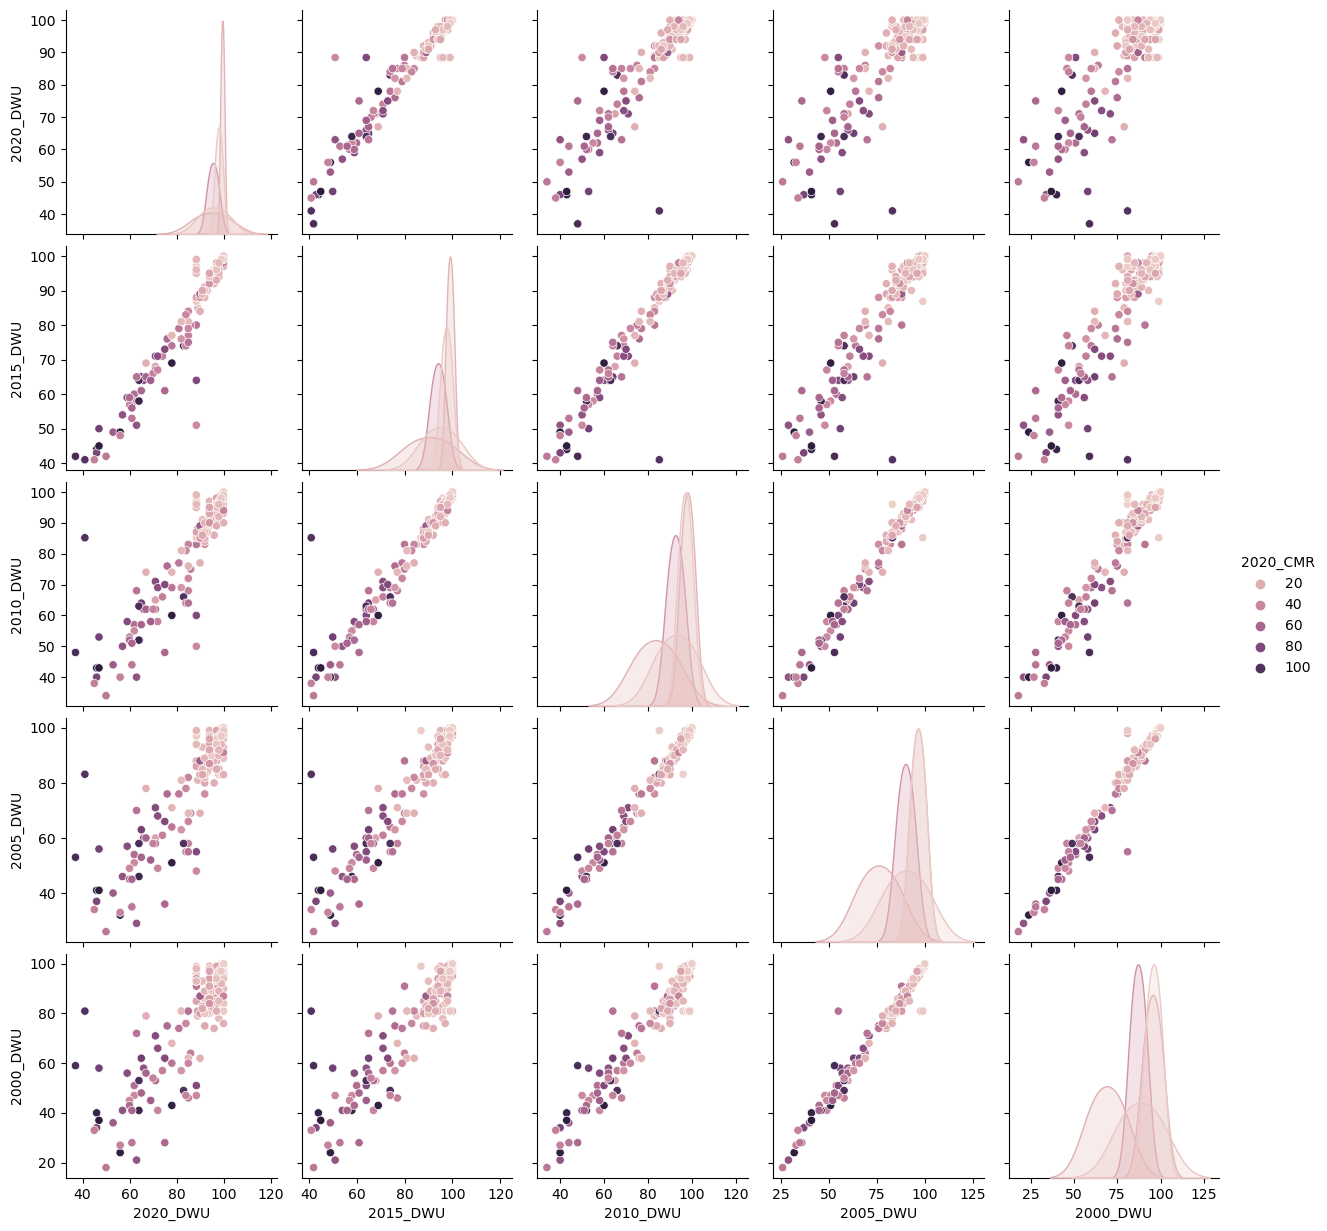

In [17]:
## NOTE that DWU: Drinking Water Usage and AMR: Adult Mortality rate

import seaborn as sns
sns.pairplot(df, hue='2020_CMR', vars=["2020_DWU", "2015_DWU", "2010_DWU", "2005_DWU", "2000_DWU",])

### 3. Implement XGboost Regression
Let's now use XGboost Regression to train a classifier on this dataset.

We start by splitting the dataset into a training set and a test set.

The training set will be used to train the model, while the test set will be used to evaluate the performance of the model.

It's important to split the data into a training set and a test set, because the model can overfit on the trainig set. When the model overfit it is able to achieve almost perfect accuracy on the training set but does not necessarily generalize well to new data and thus performs poorly on the test set. To be able to detect overfitting we always evaluate the model on a separate split of the data that we call the test set that is only used for evaluation purposes and is never used for training.

In [4]:
# Split the data into features (X) and target variable (y)
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:21].values  # Extract columns 1 to 20 for percentage of people using clean water 
y = df.iloc[:, 21:].values  # Extract columns 21 onwards for child mortality rate

# Since y contains multiple columns (20 in this case), let's select a specific column for prediction
target_column = 0  # Select the first column (year 2020) as the target
y = y[:, target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Create an XGBoost regression model
model = xgb.XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 0.7846441640777219
R-squared: 0.9977966445606014


In [6]:
# Save the model to a file
# model.save_model("child_mort_data/xgb_child_mort.model")

## 4. Create a gradio interface to interact with the model

In [1]:
import xgboost as xgb
import gradio as gr

# Load the saved model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("child_mort_data/xgb_child_mort.model")

# Define the prediction function
def predict_child_mortality_rate(percentage_clean_water):
    # Make a prediction using the loaded model
    prediction = loaded_model.predict([[percentage_clean_water]])
    return f"Predicted Child Mortality Rate: {prediction[0]:.2f}"

# Create the Gradio interface
input_text = gr.inputs.Number(label="Percentage of People Accessing Clean Water")
output_text = gr.outputs.Textbox(label="Predicted Child Mortality Rate")
interface = gr.Interface(fn=predict_child_mortality_rate, inputs=input_text, outputs=output_text)

# Launch the Gradio interface
interface.launch()

C:\Users\esspe\.conda\envs\testenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\esspe\.conda\envs\testenv\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\esspe\.conda\envs\testenv\lib\site-packages\gradio\inputs.py:62: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(value=default, label=label, optional=optional)
C:\Users\esspe\.conda\envs\testenv\lib\site-packages\gradio\outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
